In [1]:
#Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

**Data Preprocessing Part 1**

In [3]:
#Open Dataset
parkinsons_data = pd.read_csv('parkinsons_disease_data.csv')
parkinsons_data.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,FunctionalAssessment,Tremor,Rigidity,Bradykinesia,PosturalInstability,SpeechProblems,SleepDisorders,Constipation,Diagnosis,DoctorInCharge
0,3058,85,0,3,1,19.619878,0,5.108241,1.380660,3.893969,...,1.572427,1,0,0,0,0,0,0,0,DrXXXConfid
1,3059,75,0,0,2,16.247339,1,6.027648,8.409804,8.513428,...,4.787551,0,1,0,1,0,1,0,1,DrXXXConfid
2,3060,70,1,0,0,15.368239,0,2.242135,0.213275,6.498805,...,2.130686,1,0,0,0,1,0,1,1,DrXXXConfid
3,3061,52,0,0,0,15.454557,0,5.997788,1.375045,6.715033,...,3.391288,1,1,1,0,0,0,1,1,DrXXXConfid
4,3062,87,0,0,1,18.616042,0,9.775243,1.188607,4.657572,...,3.200969,0,0,0,1,0,1,0,0,DrXXXConfid


In [4]:
#Drop Irrelevant Features
pk_irr = parkinsons_data.drop('PatientID',axis=1)
pk_irr = pk_irr.drop('DoctorInCharge',axis=1)

In [5]:
##########################Function for Anomaly Removal###########################
def remove_anomalies(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    LB = Q1 - (IQR*1.5)
    UB = Q3 + (IQR*1.5)
    return (data - data[(data[feature]< LB) | (data[feature] > UB)])
###################################################################################

In [6]:
#Decouple Features and Target
pk_features = pk_irr.drop('Diagnosis',axis=1)
pk_target = pk_irr['Diagnosis']

In [7]:
#Apply SMOTE for class imbalance correction
smote = SMOTE()
pk_x_smote, pk_y_smote = smote.fit_resample(pk_features, pk_target)

**Data Visualization**

In [9]:
#Custom Palette For Visualizations
palette = {0: 'green', 1: 'red'}

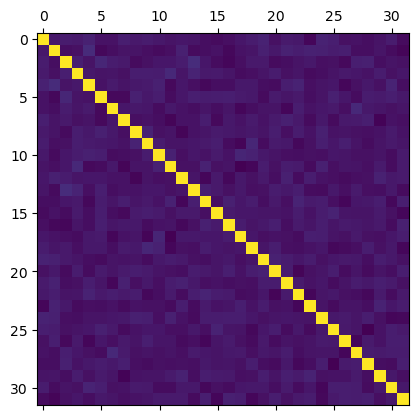

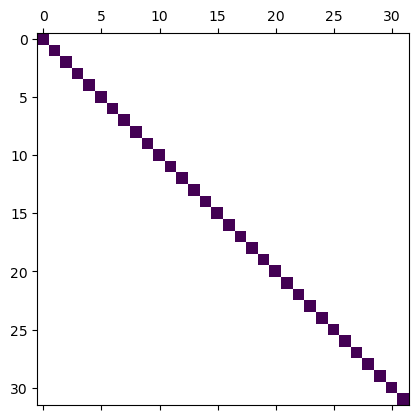

In [10]:
#Visualize Correlation
data_correlation = pk_features.corr()
data_high_correlation = data_correlation[abs(data_correlation) >= 0.5]
plt.matshow(data_correlation)
plt.matshow(data_high_correlation)

The above heatmap shows that none of the features in this dataset have a correlation above the cutoff we chose, which was 0.5. Therefore, there was no need to remove any features on account of correlation.

Diagnosis
1    1304
0     801
Name: count, dtype: int64


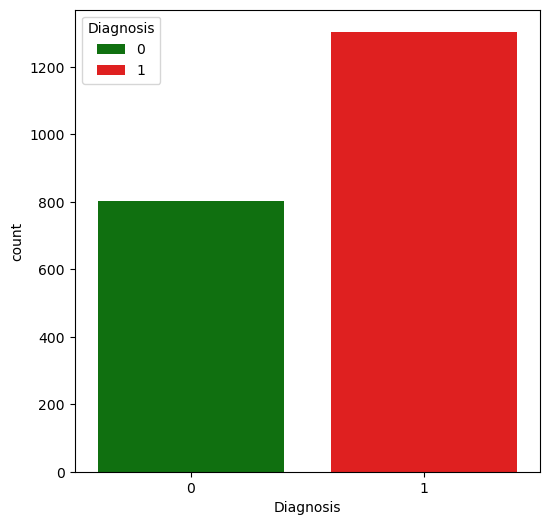

In [12]:
#Visualize Original Class Imbalance
print(pk_irr['Diagnosis'].value_counts())
plt.figure(figsize=(6, 6))
sns.countplot(x='Diagnosis', data=pk_irr, hue='Diagnosis', palette=palette)
plt.show()

There was a considerable class imbalance; most of the data points in the dataset were of the positive class (patients with parkinsons). This was corrected by applying SMOTE.

**Data Preprocessing Part 2**

In [15]:
#Scale Data
standard_scale = StandardScaler()
st_pk_x = standard_scale.fit_transform(pk_x_smote)

In [16]:
#Split Training and Testing Set
#Split Data
x_train, x_test, y_train, y_test = train_test_split(st_pk_x, pk_y_smote, train_size=.8, random_state=42)

**First Model Implementation - Simple Logistic Regression**

In [18]:
#Fit Model
logreg = LogisticRegression(random_state=42)
logreg.fit(x_train, y_train)

LogisticRegression(random_state=42)

In [19]:
#Make Predictions
logreg_pred = logreg.predict(x_test)

**First Model Evaluation - Simple Logistic Regression**

Accuracy: 0.8371647509578544
Precision: 0.846441947565543
Recall: 0.837037037037037
f1: 0.8417132216014898


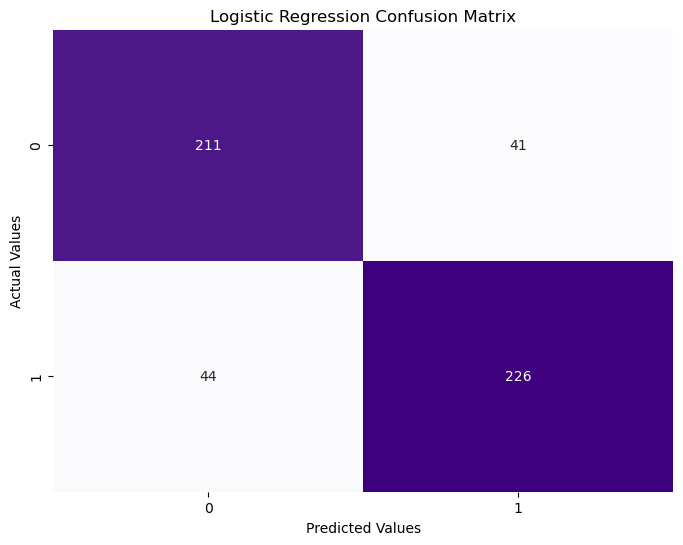

In [21]:
lr_accuracy = accuracy_score(y_test, logreg_pred)
lr_precision = precision_score(y_test, logreg_pred)
lr_recall = recall_score(y_test, logreg_pred)
lr_f1 = f1_score(y_test, logreg_pred)
lr_confusion_matrix = confusion_matrix(y_test, logreg_pred)
print("Accuracy: " + str(lr_accuracy))
print("Precision: " + str(lr_precision))
print("Recall: " + str(lr_recall))
print("f1: " + str(lr_f1))
plt.figure(figsize=(8, 6))
sns.heatmap(lr_confusion_matrix, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

**Second Model Implementation - SVM With Gaussian Kernel**

In [23]:
#Fit Model with Optimal Parameters Using GridSearchCV
svm_params = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1, 10]}
svm = GridSearchCV(estimator=SVC(kernel='rbf', random_state=42), param_grid=svm_params, scoring='f1')
svm.fit(x_train, y_train)

GridSearchCV(estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1, 10]},
             scoring='f1')

In [24]:
#Make Predictions
svm_pred = svm.predict(x_test)

**Second Model Evaluation - SVM With Gaussian Kernel**

Accuracy: 0.842911877394636
Precision: 0.8587786259541985
Recall: 0.8333333333333334
f1: 0.8458646616541353


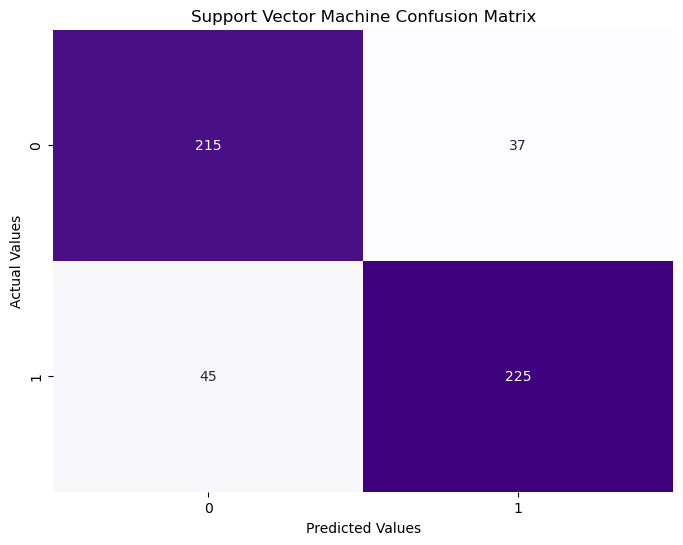

In [26]:
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_precision = precision_score(y_test, svm_pred)
svm_recall = recall_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred)
svm_confusion_matrix = confusion_matrix(y_test, svm_pred)
print("Accuracy: " + str(svm_accuracy))
print("Precision: " + str(svm_precision))
print("Recall: " + str(svm_recall))
print("f1: " + str(svm_f1))
plt.figure(figsize=(8, 6))
sns.heatmap(svm_confusion_matrix, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Support Vector Machine Confusion Matrix')
plt.show()